<h1>Welcome to the H&E Tissue Thresholding Demo!!!</h1>

Here, we demo the use of our method for rapid artefact removal and H\&E-Stained tissue segmentation. We then compare the result to the segmentation offered by Otsu thresholding.

First, let's import some stuff!

In [10]:
from he_otsu import he_otsu
from skimage.filters import threshold_otsu
from skimage.io import imread
from skimage.util import img_as_ubyte
from pathlib import Path
from skimage.color import rgb2gray, rgba2rgb
import matplotlib.pyplot as plt
import numpy as np

from utils import dice_score

To show how our algorithm works, we apply Otsu thresholding and our algorithm to a colour cube

In [11]:
colour_cube = imread(Path("./rgb_cube/colour_cubes.png"))

colour_cube_grey = rgb2gray(colour_cube[:,:,:3])
colour_cube_mask = colour_cube_grey < threshold_otsu(colour_cube_grey)
colour_cube_otsu = colour_cube * np.expand_dims(colour_cube_mask, axis = -1)  + 255*(1 - np.expand_dims(colour_cube_mask, axis = -1))

colour_cube_he_mask, _ = he_otsu(colour_cube)
colour_cube_he = colour_cube * np.expand_dims(colour_cube_he_mask, axis = -1) + + 255*(1 - np.expand_dims(colour_cube_he_mask, axis = -1))

Look how the our algorithm removes...

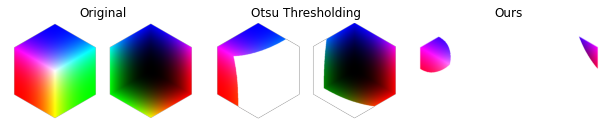

In [12]:
aspect = 0.8
fig, axes = plt.subplots(1, 3, figsize=(8.3 + 0.3, aspect * 8.3 / 3.0))

axes[0].imshow(colour_cube)
axes[0].set_title("Original")
axes[0].axis('off')
axes[1].imshow(colour_cube_otsu, cmap=plt.cm.gray)
axes[1].set_title("Otsu Thresholding")
axes[1].axis('off')
axes[2].imshow(colour_cube_he, cmap=plt.cm.gray)
axes[2].set_title("Ours")
axes[2].axis('off')

fig.tight_layout()
plt.show()


Then, we get thumbnails.

In practice, this would be stored or extracted from a WSI using ``tifffile`` or ``openslide``. Here, examples thumbnails have been saved as pngs.

In [13]:
thumbnail_filenames = sorted(list(Path("abstract_thumbnails/").glob("*.png")))
thumbnails = list(map(lambda x: rgba2rgb(imread(x)), thumbnail_filenames))

Now we use our method to create a tissue mask.

In [14]:
he_masks = []

for i, thumbnail in enumerate(thumbnails):

    he_mask, _ = he_otsu(thumbnail, blur_kernel_width=5)
    he_masks.append(he_mask)

Let's get the tissue mask provided by Otsu thresholding for comparison.

In [15]:
masks = []

for i, thumbnail in enumerate(thumbnails):

    thumbnail_grey = rgb2gray(thumbnail)
    mask = thumbnail_grey < threshold_otsu(thumbnail_grey)
    masks.append(mask)

Now we compare the segmentation provided by our method and Otsu thresholding. We do this qualitatively and with Dice score

In [16]:
aspect = 0.8
fig, axes = plt.subplots(len(thumbnails), 3, figsize=(8.3 + 0.3, len(thumbnails) * aspect * 8.3 / 3.0))

for i, thumbnail in enumerate(thumbnails):

    dice_score_of_masks = dice_score(masks[i], he_masks[i])

    axes[i, 0].imshow(thumbnail)
    axes[i, 0].set_title("Original")
    axes[i, 0].axis('off')
    axes[i, 1].imshow(masks[i], cmap=plt.cm.gray)
    axes[i, 1].set_title("Otsu")
    axes[i, 1].axis('off')
    axes[i, 2].imshow(he_masks[i], cmap=plt.cm.gray)
    axes[i, 2].set_title("Ours - Dice Score {:.2f}".format(dice_score_of_masks))
    axes[i, 2].axis('off')

fig.tight_layout()
plt.show()


We can also compare the tissue provided by our method and Otsu thresholding

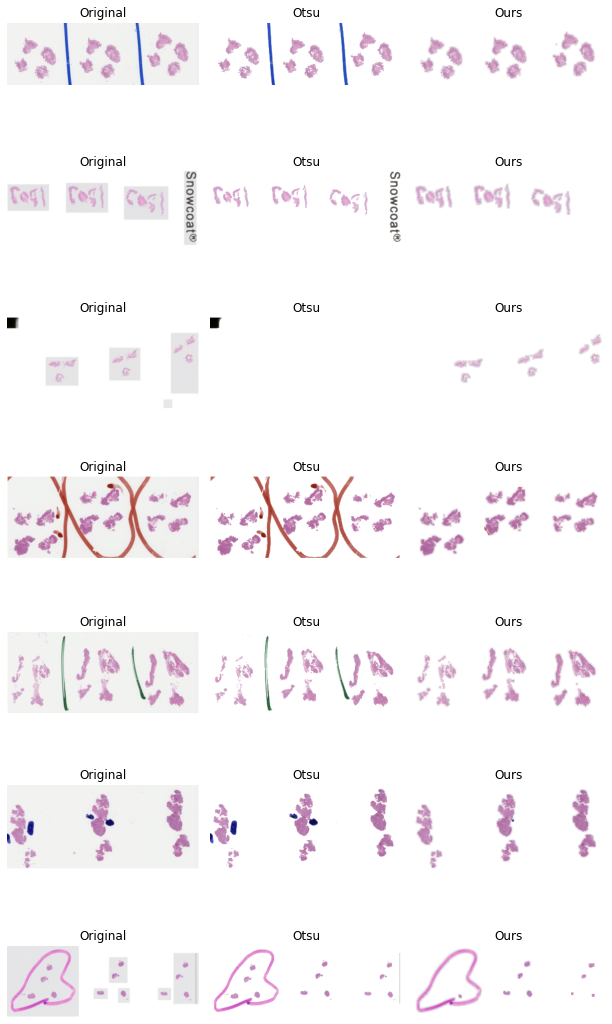

In [17]:
aspect = 0.8
fig, axes = plt.subplots(len(thumbnails), 3, figsize=(8.3 + 0.3, len(thumbnails) * aspect * 8.3 / 3.0))

for i, thumbnail in enumerate(thumbnails):

    tissue_otsu = thumbnails[i].copy()
    tissue_otsu[~masks[i], :] = 1.0

    tissue_he = thumbnails[i].copy()
    tissue_he[~he_masks[i], :] = 1.0

    axes[i, 0].imshow(thumbnail)
    axes[i, 0].set_title("Original")
    axes[i, 0].axis('off')
    axes[i, 1].imshow(tissue_otsu, cmap=plt.cm.gray)
    axes[i, 1].set_title("Otsu")
    axes[i, 1].axis('off')
    axes[i, 2].imshow(tissue_he, cmap=plt.cm.gray)
    axes[i, 2].set_title("Ours")
    axes[i, 2].axis('off')

fig.tight_layout()
plt.show()


## Comparision with Histolab

One of the main advantages of our method is its apprarent generalisability: common packages, such as [Histolab](https://histolab.readthedocs.io/en/latest/index.html), filter out pen using manually-defined thresholds. While effective, these threshods needs to be carefully matched to the data at hand, whereas our method is shown to work on different coloured pen from different sources.

Also, out approach takes care of other artefacts, such as dark spots, text and bounding boxes added by scanners en passant.

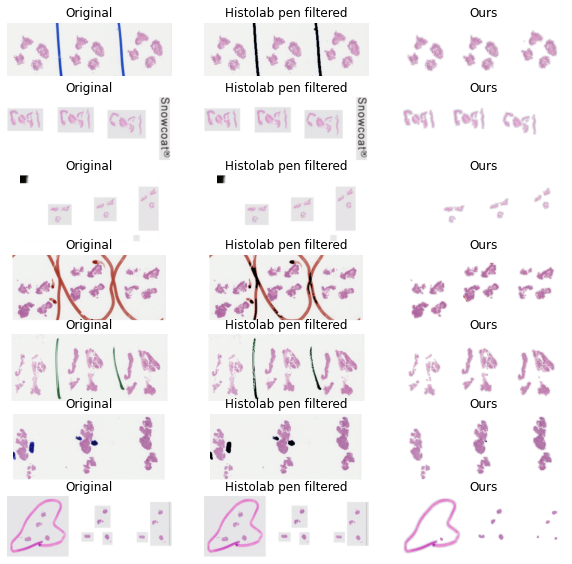

In [18]:
from histolab.filters.image_filters import RedPenFilter, GreenPenFilter, BluePenFilter

pen_filters = {"red": RedPenFilter(), "green": GreenPenFilter(), "blue": BluePenFilter(),}


figure, axes = plt.subplots(len(thumbnails), 3, figsize=(10, 10))

for i, thumbnail in enumerate(thumbnails):

    axes[i, 0].imshow(thumbnail)
    axes[i, 0].set_title("Original")

    image = img_as_ubyte(thumbnail)
    for key in pen_filters:
        image = pen_filters[key](image)

    axes[i, 1].imshow(image)
    axes[i, 1].set_title("Histolab pen filtered")

    to_plot = thumbnails[i].copy()
    to_plot[~he_masks[i], :] = 1.0
    axes[i, 2].imshow(to_plot, cmap="Greys_r")
    axes[i, 2].set_title("Ours")

for axis in axes.ravel():
    axis.axis("off")
